In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
from sklearn.metrics import roc_auc_score

## Convert OOFs and Ground Truth to NumPy

First, we define a function `return_list_of_dataframes` to return either the OOFs or the SUBs. At this point, one should be clear what are OOFs, if not, please read the post [here](https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/175614).

In [3]:
def return_list_of_dataframes(
    path: str, is_oof: bool = True
) -> Tuple[List[pd.DataFrame], int]:
    """Return a list of dataframes from a directory of files.

    The boolean is_oof is used to determine whether the list of dataframes contains oof or subs.

    Args:
        path (str): The path to the directory containing the files.
        is_oof (bool, optional): Determine whether the list of dataframes contains oof or subs. Defaults to True.

    Returns:
        List[pd.DataFrame]: The list of dataframes for either oof or subs.
        int: The number of files in the directory.
    """
    oof_and_subs_files = os.listdir(path)

    if is_oof:
        oof_files_sorted = np.sort(
            [f for f in oof_and_subs_files if "oof" in f]
        )
        return [
            pd.read_csv(os.path.join(path, k)) for k in oof_files_sorted
        ], len(oof_files_sorted)

    else:
        sub_files_sorted = np.sort(
            [f for f in oof_and_subs_files if "sub" in f]
        )
        return [
            pd.read_csv(os.path.join(path, k)) for k in sub_files_sorted
        ], len(sub_files_sorted)



This function is first applied to `is_oof=True`. For now, we just want all our OOFs converted to a pandas dataframe, and stored in a list.

Note, we also conveniently returned the number of files in the director for OOFs and SUBs respectively, it should be clear in this context that the number of files for OOF is the same as the number of files for SUB.

In [4]:
oof_and_subs_path = "./oof_and_subs/toy_examples"
oof_dfs_list, num_oofs = return_list_of_dataframes(path=oof_and_subs_path, is_oof=True)

display(oof_dfs_list[0])
display(oof_dfs_list[1])
display(oof_dfs_list[2])
print(f"We have {num_oofs} oof files.\n")

,image_id,y_trues,class_0_oof,class_1_oof
0,1,1,0.70,0.30
1,2,0,0.70,0.30
2,3,0,0.65,0.35


,image_id,y_trues,class_0_oof,class_1_oof
0,1,1,0.6,0.4
1,2,0,0.8,0.2
2,3,0,0.4,0.6


,image_id,y_trues,class_0_oof,class_1_oof
0,1,1,0.1,0.8
1,2,0,0.4,0.8
2,3,0,0.9,0.7


We have 3 oof files.



At this junction, we need to be clear of a few things. Let us use an example to illustrate.

Let us say we trained our model over 5 folds and get our OOF predictions in terms of the **Macro-AUROC** with respect to the positive **class 1**. We then need to calculate our OOF scores with our corresponding y_trues.

Just by eyeballing, we can deduce the **Macro-AUROC** score for the positive class as follows:

```python
oof_1_auroc = roc_auc_score([1,0,0], [0.3, 0.3, 0.35]) -> 0.25
oof_2_auroc = roc_auc_score([1,0,0], [0.4, 0.2, 0.6])  -> 0.5
oof_3_auroc = roc_auc_score([1,0,0], [0.8, 0.8, 0.7])  -> 0.75
```

To compute the above, we can manually hardcode them, but for larger data, we will have to maintain a better data structure. We will store them into matrices and vectors (numpy) to compute the OOF scores efficiently.

To do so, we define two variables:

```python
ground_truth_column_name = ["y_trues"]
positive_class_oof_column_name = ["class_1_oof"]
```
where the first variable is the name of the column(s) for the ground truth, while the second is the name of the column(s) that we will be using to compute the OOF scores.

We will then create a function `stack_oofs` to convert the list of OOF dataframes into an array.

In [5]:
def stack_oofs(
    oof_dfs: List[pd.DataFrame], pred_column_names: List[str]
) -> np.ndarray:
    """Stack all oof predictions horziontally.

    Args:
        oof_dfs (List[pd.DataFrame]): The list of oof predictions in dataframes.
        pred_column_names (List[str]): The list of prediction column names.

    Returns:
        all_oof_preds (np.ndarray): The stacked oof predictions of shape (num_samples, num_oofs * num_pred_columns).

    Example:
        >>> oof_1 = pd.DataFrame([1,2,3], columns=['class_1_oof'])
        >>> oof_2 = pd.DataFrame([4,5,6], columns=['class_1_oof'])
        >>> all_oof_preds = stack_oofs([oof_1, oof_2], ['class_1_oof'])
        >>> all_oof_preds = np.array([1, 4], [2, 5], [3, 6])
    """
    num_oofs = len(oof_dfs)
    num_samples = len(oof_dfs[0])
    num_target_cols = len(pred_column_names)
    all_oof_preds = np.zeros((num_samples, num_oofs * num_target_cols))

    if num_target_cols == 1:
        for index, oof_df in enumerate(oof_dfs):
            all_oof_preds[:, index : index + 1] = oof_df[
                pred_column_names
            ].values

    elif num_target_cols > 1:
        # Used in RANZCR where there are 11 target columns
        for index, oof_df in enumerate(oof_dfs):
            all_oof_preds[
                :, index * num_target_cols : (index + 1) * num_target_cols
            ] = oof_df[pred_column_names].values

    return all_oof_preds

In [6]:
ground_truth_column_name = ["y_trues"]
positive_class_oof_column_name = ["class_1_oof"]

In my oof files, I also saved the corresponding `y_trues` as a column, we thus take the first `oof_df` from `oof_dfs_list` and use it to get the `y_trues`, assuming they are the same for all oof files. Note of caution, if you use different resampling methods, you will need to change the `y_trues` accordingly.

In [7]:
y_trues = oof_dfs_list[0][ground_truth_column_name].values
all_oof_preds = stack_oofs(oof_dfs_list, positive_class_oof_column_name)

print(
    f"y_trues shape: {y_trues.shape}\nThis variable is global and holds all ground truth.\n"
)
print(
    f"all_oof_preds shape: {all_oof_preds.shape}\nThis variable is global and holds all oof predictions stacked horizontally.\n"
)

y_trues shape: (3, 1)
This variable is global and holds all ground truth.

all_oof_preds shape: (3, 3)
This variable is global and holds all oof predictions stacked horizontally.



After converting to numpy, we should have this following representation:

$$
\textbf{y_true} = \begin{bmatrix} 1 \\ 0 \\ 0 \end{bmatrix} \in \mathbb{R}^3 \quad \textbf{all_oof_preds} = \begin{bmatrix} 0.3 & 0.4 & 0.8 \\ 0.3 & 0.2 & 0.8 \\ 0.35 & 0.6 & 0.7 \end{bmatrix} \in \mathbb{R}^{3 \times 3}
$$

where **y_true** is a $3 \times 1$ column vector, each row entry is the corresponding ground truth for sample $i$ (i.e `y_true[0]` is ground truth for sample 1). 

For **all_oof_preds**, this is a $3 \times 3$ matrix, where each **column** $i$ represents the OOF predictions made by model $i$. In other words, the first column $\begin{bmatrix} 0.3 \\ 0.35 \\ 0.3 \end{bmatrix}$ is the OOF predictions made by the first model. It is important to note that we are dealing with classification (binary or multiclass), so it is usually the case that both our target and predicted columns are just $1$. In **multi-label** however, we will have multiple target columns, and will be the focus in part II.

## Compute Scores of OOFs and Find the Best Score

This part is very crucial, when we apply our **Hill Climbing (Forward Ensembling)** technique here, we want to initialize with the best models first and **iteratively blend with the rest**.

In other words

In [8]:
def compute_best_oof(
    all_oof_preds: np.ndarray,
    y_trues: np.ndarray,
    num_oofs: int,
    performance_metric: Callable,
) -> Tuple[float, int]:
    """Compute the oof score of all models using a performance metric and return the best model index and score.

    Args:
        all_oof_preds (np.ndarray): The stacked oof predictions of shape (num_samples, num_oofs * num_pred_columns). Taken from stack_oofs.
        y_trues (np.ndarray): The true labels of shape (num_samples, num_target_cols).
        num_oofs (int): The number of oof predictions.
        performance_metric (Callable): The performance metric to use, this is a function.

    Returns:
        best_oof_metric_score (float): The best oof score.
        best_model_index (int): The index of the best model.
    """
    all_oof_scores = []
    for k in range(num_oofs):
        oof_k = all_oof_preds[:, k].reshape(-1,1)
        metric_score = performance_metric(
            y_trues,
            oof_k,
            num_target_cols=1,
            multilabel=False,
        )
        all_oof_scores.append(metric_score)
        print(f"Model {k} has OOF AUC = {metric_score}")

    best_oof_metric_score, best_oof_index = np.max(all_oof_scores), np.argmax(
        all_oof_scores
    )
    return best_oof_metric_score, best_oof_index

In [9]:
def macro_multilabel_auc(
    label, pred, num_target_cols: int = 1, multilabel: bool = False
):
    """Also works for binary AUC like Melanoma"""

    if not multilabel:
        return roc_auc_score(label, pred)
    else:
        aucs = []
        for i in range(num_target_cols):
            print(label[:, i])
            print()
            print(pred[:, i])
            print(roc_auc_score(label[:, i], pred[:, i]))
        aucs.append(roc_auc_score(label, pred))

        return np.mean(aucs)

In [12]:
best_oof_metric_score, best_oof_index = compute_best_oof(
    all_oof_preds=all_oof_preds,
    y_trues=y_trues,
    num_oofs=num_oofs,
    performance_metric=macro_multilabel_auc,
)

print(
    f"\n### Computing Best OOF scores among all models ###\nThe best OOF AUC score is {best_oof_metric_score} and the best model index is {best_oof_index} corresponding to the oof file {best_oof_index}"
)

Model 0 has OOF AUC = 0.25
Model 1 has OOF AUC = 0.5
Model 2 has OOF AUC = 0.75

### Computing Best OOF scores among all models ###
The best OOF AUC score is 0.75 and the best model index is 2 corresponding to the oof file 2


## The Algorithm

Now the logic flows as follows:

- Start with the model with the best OOF score: we get that from `compute_best_oof` which yields us the key variables `best_oof_index`. 
    - `best_oof_index`: 2 indicates that our oof_2 (model 2) has the best OOF score amongst the 3 OOFs (models), as we can see from above, it is indeed the case since Model 2 has OOF AUC of $0.75$.
- We now need to blend **Model 2** with **Model 0** and **Model 1** respectively to find out which weight combination gives a better OOF score.
    - We need to define a variable `weight_interval`, which tells us the weights to sample from. For example, if `weight_interval` is $3$, then we will uniformly sample the weights $\frac{0}{3}, \frac{1}{3}, \frac{2}{3}$. Let us see a concrete example.

In [13]:
weight_interval = 3
patience_counter = 0
model_0_oof = all_oof_preds[:, 0].reshape(y_trues.shape)
model_1_oof = all_oof_preds[:, 1].reshape(y_trues.shape)
model_2_oof = all_oof_preds[:, best_oof_index].reshape(y_trues.shape) # best_oof_index=2

We define

```python
best_oof_index_list = [best_oof_index]
best_weights_list = []
```

which keeps track two lists which holds the best OOFs to blend with and their corresponding weights.

We use a naive example to illustrate:

```python
best_oof_index_list = [2, 0, 1]
best_weights_list = [0.3, 0.8]
all_oof_preds_matrix = [[0.3, 0.4, 0.8],
                        [0.3, 0.2, 0.8],
                        [0.35, 0.6, 0.7]]
initial_best_vector = A_matrix[:, 2]
```

In other words, if after our Hill Climbing algorithm, we have the above variables and to calculate the **final blended OOF** using the above optimal weights, we have:

Let $\mathbf{c_i}$ be the columns of the matrix **all_oof_preds_matrix**, you can think $\mathbf{c_i}$ as the Model $i$'s OOFs predictions, since in this naive example, we see that our initial best model is Model 2.

$$
((1-0.3) \times \mathbf{c_2} + 0.3 \times \mathbf{c_0}) \times (1-0.8) + 0.8 \times \mathbf{c_1}
$$

1. To dissect clearly, we start with the first index, which is Model 2, and blend with the next index, which is Model 0, they will be blended with weights of $0.3$, which means $(1-0.3) \times \mathbf{c_2} + 0.3 \times \mathbf{c_0}$. We call it **oof_blend_1** which indicates the linear combination of the weights of the first blend. Note that this results in a new and better "OOF predictions".
2. The next blend will be of **oof_blend_1** with Model 1, with a weight of $0.8$ and the assignment is $(1-0.8) \times \textbf{oof_blend_1} + 0.8 \times \mathbf{c_0}$.

In [14]:
best_oof_index_list = [best_oof_index]
best_weights_list = []
print(f"Current Tracked Model List: {best_oof_index_list}")
print(f"Current Weights List: {best_weights_list}")

Current Tracked Model List: [2]
Current Weights List: []


### First Round - Blending Model 2 with Model 0

- We check the blending results of Model 2 and Model 0 over 3 weights: $0, \frac{1}{3}, \frac{2}{3}$. 
- We also assign 3 variables
```python
running_best_score, running_best_weight, running_best_oof_index = best_oof_metric_score, 0, 0
```
such that whenever a blend of $w_1 \times \textbf{model_i_oof} + (1-w_2) \times \textbf{model_j_oof}$ produces a better OOF score, then we will assign 

```python
if temp_ensemble_oof_score >= running_best_score:
    print(f"The blend of weight {temp_weight} of model 2 and model 0 led to a greater or equals to OOF score = {temp_ensemble_oof_score}\n")
    running_best_score = temp_ensemble_oof_score
    running_best_weight = temp_weight
    running_best_oof_index = 0
```

Notice that we **hardcoded** the `running_best_oof_index` to be $0$ since we know we are only looking at the interaction of Model 2 and Model 0. In proper code, this part should not be hardcoded and you can refer to my full code for clarity.

In [15]:
running_best_score, running_best_weight, running_best_oof_index = best_oof_metric_score, 0, 0

for weight in range(weight_interval):
    temp_weight = weight / weight_interval
    print(f"weight = {temp_weight}")

    temp_ensemble_oof_preds = (
        temp_weight * model_0_oof + (1 - temp_weight) * model_2_oof
    )

    temp_ensemble_oof_score = macro_multilabel_auc(
        y_trues,
        temp_ensemble_oof_preds,
        num_target_cols=1,
        multilabel=False,
    )
    print(f"blended OOF score with model_0_oof = {temp_ensemble_oof_score}")
    
    if temp_ensemble_oof_score >= running_best_score:
        running_best_score = temp_ensemble_oof_score
        running_best_weight = temp_weight
        running_best_oof_index = 0
        print(f"The blend of weight {temp_weight} of model 2 and model {running_best_oof_index} led to a greater or equals to OOF score = {temp_ensemble_oof_score}\n")

weight = 0.0
blended OOF score with model_0_oof = 0.75
The blend of weight 0.0 of model 2 and model 0 led to a greater or equals to OOF score = 0.75

weight = 0.3333333333333333
blended OOF score with model_0_oof = 0.75
The blend of weight 0.3333333333333333 of model 2 and model 0 led to a greater or equals to OOF score = 0.75

weight = 0.6666666666666666
blended OOF score with model_0_oof = 0.5


So now we finished blending Model 2 and Model 0 and we have:

```python
running_best_score = 0.75
running_best_weight = 0.333...
```

We need to blend Model 2 and Model 1 now to see if Model 2 and Model 1 can give better OOF scores when blended! We repeat the exact same loop as above, but bear in mind that the `running_best_score` and `running_best_weight` is already updated to the ones we got in the blend of Model 2 and Model 0 because we want to check if Model 2 and Model 1's blend can give better results than the previous `running_best_score`. 

### First Round - Blending Model 2 and Model 1

In [16]:
for weight in range(weight_interval):
    temp_weight = weight / weight_interval
    print(f"weight = {temp_weight}")
    temp_ensemble_oof_preds = (
        temp_weight * model_1_oof + (1 - temp_weight) * model_2_oof
    )

    temp_ensemble_oof_score = macro_multilabel_auc(
        y_trues,
        temp_ensemble_oof_preds,
        num_target_cols=1,
        multilabel=False,
    )
    print(f"blended OOF score with model_1_oof = {temp_ensemble_oof_score}")
    
    if temp_ensemble_oof_score >= running_best_score:
        running_best_score = temp_ensemble_oof_score
        running_best_weight = temp_weight
        running_best_oof_index = 1
        print(f"The blend of weight {temp_weight} of model 2 and model {running_best_oof_index} led to a greater or equals to OOF score = {temp_ensemble_oof_score}\n")

weight = 0.0
blended OOF score with model_1_oof = 0.75
The blend of weight 0.0 of model 2 and model 1 led to a greater or equals to OOF score = 0.75

weight = 0.3333333333333333
blended OOF score with model_1_oof = 1.0
The blend of weight 0.3333333333333333 of model 2 and model 1 led to a greater or equals to OOF score = 1.0

weight = 0.6666666666666666
blended OOF score with model_1_oof = 0.5


So now we finished blending Model 2 and Model 1 and we have:

```python
running_best_score = 1
running_best_weight = 0.333...
```

and we have a new winner in town! After our first round of iterating our **initial best OOF Model 2** with the rest (Model 0 and 1), we found out that if we take $w_1 = 1 - \frac{2}{3}$ and $w_2 = \frac{1}{3}$, Model 2 and 1 gives us a better overall score.

That is to say:

$$
w_1 * \textbf{OOF_2} + w_2 \times \textbf{OOF_1}
$$

leads to the greatest increase in our OOF score!

Notice that we **hardcoded** the `running_best_oof_index` to be $1$ since we know we are only looking at the interaction of Model 2 and Model 1. In proper code, this part should not be hardcoded and you can refer to my full code for clarity.

Technically, we can stop the algorithm now since the metric **Macro-AUROC** is capped at $1$, but for the sake of explanation, let us continue.

### First Round - Save Results for Loop 1

We then append the best OOF index and the corresponding weight to the `best_oof_index_list` and `best_weights_list` respectively.

In [17]:
best_oof_index_list.append(running_best_oof_index)
best_weights_list.append(running_best_weight)

print(f"Current Tracked Model List: {best_oof_index_list}")
print(f"Current Weights List: {best_weights_list}")

Current Tracked Model List: [2, 1]
Current Weights List: [0.3333333333333333]


### Second Round - Blend OOF

Now we have a brand new OOF after blending Model 2 and Model 1, we call it **blended_oof_1** and note that this is our new best OOF!

In [18]:
# blended_oof_1 = all_oof_preds[:, best_oof_index_list[0]].reshape(-1, 1) * (1 - best_weights_list[0]) + all_oof_preds[:, best_oof_index_list[1]].reshape(-1, 1) * best_weights_list[0]
blended_oof_1 = model_2_oof * (1 - 1/3) + model_1_oof * (1/3)
assert macro_multilabel_auc(y_trues, blended_oof_1) == 1

### Second Round - Blending blended_oof_1 with Model 0

We continue to try out **blended_oof_1** with the rest of the models that were not selected. This means we have to check our **Current Tracked Model List** `best_oof_index_list` and see that we already have $[2, 1]$ being used up, in our simple example here, there only left with Model 0 to try! So make sure in your code you do not try **blended_oof_1** with Model 0, 1 and 2 again since the **blended_oof_1** is already made up with Model 1 and 2!

In [19]:
for weight in range(weight_interval):
    temp_weight = weight / weight_interval
    print(f"\nweight = {temp_weight}")

    temp_ensemble_oof_preds = (
        temp_weight * model_0_oof + (1 - temp_weight) * blended_oof_1
    )

    temp_ensemble_oof_score = macro_multilabel_auc(
        y_trues,
        temp_ensemble_oof_preds,
        num_target_cols=1,
        multilabel=False,
    )
    print(f"blended OOF score with model_0_oof = {temp_ensemble_oof_score}")
    
    if temp_ensemble_oof_score >= running_best_score:
        running_best_score = temp_ensemble_oof_score
        running_best_weight = temp_weight
        running_best_oof_index = 0
        print(f"The blend of weight {temp_weight} of model 2 and model {running_best_oof_index} led to a greater or equals to OOF score = {temp_ensemble_oof_score}\n")


weight = 0.0
blended OOF score with model_0_oof = 1.0
The blend of weight 0.0 of model 2 and model 0 led to a greater or equals to OOF score = 1.0


weight = 0.3333333333333333
blended OOF score with model_0_oof = 0.5

weight = 0.6666666666666666
blended OOF score with model_0_oof = 0.5


Since we have done checking **blended_oof_1** with the last remaining Model 0 and found that blending Model 0 with a weight of 0 (what a surprise haha!) yields the best result, we once again update the `running` metrics and also append to our global lists below.

In [20]:
best_oof_index_list.append(running_best_oof_index)
best_weights_list.append(running_best_weight)

print(f"Current Tracked Model List: {best_oof_index_list}")
print(f"Current Weights List: {best_weights_list}")

Current Tracked Model List: [2, 1, 0]
Current Weights List: [0.3333333333333333, 0.0]


In [21]:
# blended_oof_2 = blended_oof_1 * (1 - best_weights_list[1]) + all_oof_preds[:, best_oof_index_list[2]].reshape(-1, 1) * best_weights_list[1]
blended_oof_2 = blended_oof_1 * (1 - 0.0) + model_0_oof.reshape(-1, 1) * 0.0
assert macro_multilabel_auc(y_trues, blended_oof_2) == 1

## Ensembling Model Predictions with the Found Optimal Weights

So we end the discussion with what to do with the weights we got. We already established to the readers that our **Initial Best OOF is Model 2** with a **Macro-AUROC** score of $0.75$, and by way of Hill Climbing, we found out that we can blend the 3 Models with some weights such that their new OOF produces a **Macro-AUROC** score of $1.0$, a huge improvement. We aren't done yet! We want to apply these optimal weights to our **test set predictions** as well. Note that our **test set predictions** are **unseen** and our usual ensemble methods can be as simple as mean averaging.

More concretely, let us check out the example below.

In [23]:
oof_and_subs_path = "./oof_and_subs/toy_examples"
sub_dfs_list, num_subs = return_list_of_dataframes(path=oof_and_subs_path, is_oof=False)

display(sub_dfs_list[0])
display(sub_dfs_list[1])
display(sub_dfs_list[2])
print(f"We have {num_subs} sub files.\n")

,image_id,class_0_preds,class_1_preds
0,4,0.2,0.8
1,5,0.3,0.7
2,6,0.6,0.4


,image_id,class_0_preds,class_1_preds
0,4,0.3,0.7
1,5,0.9,0.1
2,6,0.2,0.8


,image_id,class_0_preds,class_1_preds
0,4,0.3,0.7
1,5,0.7,0.3
2,6,0.8,0.2


We have 3 sub files.



The `stack_subs` function does the same thing as `stack_oofs` so they can be combined into one function for code clarity.

In [24]:
def stack_subs(
    sub_dfs: List[pd.DataFrame], pred_column_names: List[str]
) -> np.ndarray:
    """Stack all sub predictions horziontally.

    Args:
        sub_dfs (List[pd.DataFrame]): The list of sub predictions in dataframes.
        pred_column_names (List[str]): The list of prediction column names.

    Returns:
        all_sub_preds (np.ndarray): The stacked oof predictions of shape (num_samples, num_subs * num_pred_columns).
    """
    num_subs = len(sub_dfs)
    num_samples = len(sub_dfs[0])
    num_target_cols = len(pred_column_names)
    all_sub_preds = np.zeros((num_samples, num_subs * num_target_cols))

    if num_target_cols == 1:
        for index, sub_df in enumerate(sub_dfs):
            all_sub_preds[:, index : index + 1] = sub_df[
                pred_column_names
            ].values

    elif num_target_cols > 1:
        # Used in RANZCR where there are 11 target columns
        for index, sub_df in enumerate(sub_dfs):
            all_sub_preds[
                :, index * num_target_cols : (index + 1) * num_target_cols
            ] = sub_df[pred_column_names].values

    return all_sub_preds

In [25]:
test_set_target_column_name = ["class_1_preds"]
all_subs_preds = stack_subs(sub_dfs_list, test_set_target_column_name)

In [26]:
model_0_sub = all_subs_preds[:, 0].reshape(y_trues.shape)
model_1_sub = all_subs_preds[:, 1].reshape(y_trues.shape)
model_2_sub = all_subs_preds[:, 2].reshape(y_trues.shape) 

Recall the optimal weights earlier:

```python
Current Tracked Model List: [2, 1, 0]
Current Weights List: [0.3333333333333333, 0.0]
```

and we now have a way to ensemble our model subs accordingly.

In [27]:
# blended_oof_1 = all_oof_preds[:, best_oof_index_list[0]].reshape(-1, 1) * (1 - best_weights_list[0]) + all_oof_preds[:, best_oof_index_list[1]].reshape(-1, 1) * best_weights_list[0]
blended_sub_1 = model_2_sub * (1 - 1/3) + model_1_sub * (1/3)
blended_sub_2 = blended_sub_1 * (1-0.0) + model_0_sub * 0.0

In [28]:
blended_sub_2

array([[0.7       ],
       [0.23333333],
       [0.4       ]])

Then `blended_sub_2` should be our final **test set predictions**!

## Forward Ensemble with SIIM-ISIC Melanoma Classification

This is taken from my repo.

We have 6 oof files.

all_oof_preds shape: (33126, 6)
This variable is global and holds all oof predictions stacked horizontally.

Model 0 has OOF AUC = 0.8967598406021975
Model 1 has OOF AUC = 0.897338308007439
Model 2 has OOF AUC = 0.8969099101014242
Model 3 has OOF AUC = 0.8997782002268091
Model 4 has OOF AUC = 0.9021602904318382
Model 5 has OOF AUC = 0.9035525112752076

### Computing Best OOF scores among all models ###
The best OOF AUC score is 0.9035525112752076 and the best model index is 5 corresponding to the oof file oof_tf_efficientnet_b2_ns_tf_efficientnet_b2_ns_5_folds_3c0odinh.csv

### HyperParameters ###
weight_interval = 1000
patience = 20
min_increase = 0.0003

Current Tracked Model List: [5]
Current Weights List: []
Denote model i as the current model, and model j as the model that we are blending with.

Ensemble AUC = 0.9141 after adding model 2 with weight 0.452. Increase of 0.0106

Current Tracked Model List: [5, 2]
Current Weights List: [0.452]
Current Best Score:

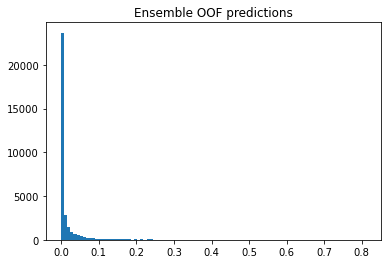


We have 6 submission files...

['sub_tf_efficientnet_b0_ns_tf_efficientnet_b0_ns_5_folds_2dcluilj.csv'
 'sub_tf_efficientnet_b0_ns_tf_efficientnet_b0_ns_5_folds_3725vib5.csv'
 'sub_tf_efficientnet_b0_ns_tf_efficientnet_b0_ns_5_folds_kh6lm0mc.csv'
 'sub_tf_efficientnet_b1_ns_tf_efficientnet_b1_ns_5_folds_9qhxwbbq.csv'
 'sub_tf_efficientnet_b2_ns_tf_efficientnet_b2_ns_5_folds_1lvjyja0.csv'
 'sub_tf_efficientnet_b2_ns_tf_efficientnet_b2_ns_5_folds_3c0odinh.csv']
(10982, 6)
[[1.10712990e-03 4.36813570e-04 5.27769700e-04 5.15609340e-04
  7.12666400e-04 4.17358470e-04]
 [2.20565100e-04 1.78343150e-04 9.28863160e-05 1.78823610e-05
  1.48618330e-04 3.16100000e-05]
 [1.81065010e-04 7.23641860e-05 2.92848130e-04 7.86881400e-05
  9.41391550e-05 9.77370900e-05]
 ...
 [6.67065500e-02 1.14237880e-01 1.26132040e-01 1.13317326e-01
  6.87497260e-02 7.28674750e-02]
 [6.35771550e-03 6.06310670e-04 8.84217040e-04 9.36840800e-04
  5.04250900e-04 5.87228570e-05]
 [1.41756660e-02 2.95386670e-02 1.08320400e-

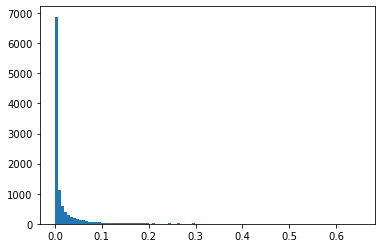

In [29]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from typing import List, Tuple, Callable
from sklearn.metrics import roc_auc_score

def stack_oofs(
    oof_dfs: List[pd.DataFrame], pred_column_names: List[str]
) -> np.ndarray:
    """Stack all oof predictions horziontally.
    Args:
        oof_dfs (List[pd.DataFrame]): The list of oof predictions in dataframes.
        pred_column_names (List[str]): The list of prediction column names.
    Returns:
        all_oof_preds (np.ndarray): The stacked oof predictions of shape (num_samples, num_oofs * num_pred_columns).
    Example:
        >>> oof_1 = pd.DataFrame([1,2,3], columns=['class_1_oof'])
        >>> oof_2 = pd.DataFrame([4,5,6], columns=['class_1_oof'])
        >>> all_oof_preds = stack_oofs([oof_1, oof_2], ['class_1_oof'])
        >>> all_oof_preds = np.array([1, 4], [2, 5], [3, 6])
    """
    num_oofs = len(oof_dfs)
    num_samples = len(oof_dfs[0])
    num_target_cols = len(pred_column_names)
    all_oof_preds = np.zeros((num_samples, num_oofs * num_target_cols))

    if num_target_cols == 1:
        for index, oof_df in enumerate(oof_dfs):
            all_oof_preds[:, index : index + 1] = oof_df[
                pred_column_names
            ].values

    elif num_target_cols > 1:
        # Used in RANZCR where there are 11 target columns
        for index, oof_df in enumerate(oof_dfs):
            all_oof_preds[
                :, index * num_target_cols : (index + 1) * num_target_cols
            ] = oof_df[pred_column_names].values

    return all_oof_preds


def macro_multilabel_auc(
    label, pred, num_target_cols: int = 1, multilabel: bool = False
):
    """Also works for binary AUC like Melanoma"""

    if not multilabel:
        return roc_auc_score(label, pred)
    else:
        aucs = []
        for i in range(num_target_cols):
            print(label[:, i])
            print()
            print(pred[:, i])
            print(roc_auc_score(label[:, i], pred[:, i]))
        aucs.append(roc_auc_score(label, pred))

        return np.mean(aucs)


def compute_best_oof(
    all_oof_preds: np.ndarray,
    y_trues: np.ndarray,
    num_oofs: int,
    performance_metric: Callable,
) -> Tuple[float, int]:
    """Compute the oof score of all models using a performance metric and return the best model index and score.
    Args:
        all_oof_preds (np.ndarray): The stacked oof predictions of shape (num_samples, num_oofs * num_pred_columns). Taken from stack_oofs.
        y_trues (np.ndarray): The true labels of shape (num_samples, num_target_cols).
        num_oofs (int): The number of oof predictions.
        performance_metric (Callable): The performance metric to use, this is a function.
    Returns:
        best_oof_metric_score (float): The best oof score.
        best_model_index (int): The index of the best model.
    """
    all_oof_scores = []
    for k in range(num_oofs):
        metric_score = performance_metric(
            y_trues,
            all_oof_preds[:, k],
            num_target_cols=1,
            multilabel=False,
        )
        all_oof_scores.append(metric_score)
        print(f"Model {k} has OOF AUC = {metric_score}")

    best_oof_metric_score, best_oof_index = np.max(all_oof_scores), np.argmax(
        all_oof_scores
    )
    return best_oof_metric_score, best_oof_index


def calculate_best_score_over_weight_interval(
    weight_interval: float,
    model_i_oof: np.ndarray,
    model_j_oof: np.ndarray,
    y_trues: np.ndarray,
    performance_metric: Callable,
    running_best_score: float,
    running_best_weight: float,
    patience: int,
) -> Tuple[float, float]:
    """Calculate the best score over a weight interval.
    Args:
        weight_interval (float): _description_
        model_i_oof (np.ndarray): _description_
        model_j_oof (np.ndarray): _description_
        y_trues (np.ndarray): _description_
        performance_metric (Callable): _description_
        running_best_score (float): _description_
        running_best_weight (float): _description_
        patience (int): _description_
    Returns:
        Tuple[float, float]: _description_
    """
    patience_counter = 0
    for weight in range(weight_interval):
        temp_weight = weight / weight_interval

        temp_ensemble_oof_preds = (
            temp_weight * model_j_oof + (1 - temp_weight) * model_i_oof
        )

        temp_ensemble_oof_score = performance_metric(
            y_trues,
            temp_ensemble_oof_preds,
            num_target_cols=1,
            multilabel=False,
        )

        # in the first loop, if any of the blending is more than best_oof_metric_score, we will assign it to running_best_score.

        if temp_ensemble_oof_score > running_best_score:
            running_best_score = temp_ensemble_oof_score
            running_best_weight = temp_weight

        else:
            patience_counter += 1
            if patience_counter > patience:
                break

    return running_best_score, running_best_weight


def get_blended_oof(
    initial_best_model_oof, best_oof_index_list, best_weights_list
):
    # can be used on both oof and subs

    curr_model_oof = initial_best_model_oof
    for index, _ in enumerate(best_oof_index_list[1:]):
        model_j_index = best_oof_index_list[index + 1]

        curr_model_oof = (1 - best_weights_list[index]) * curr_model_oof + (
            best_weights_list[index]
        ) * all_oof_preds[:, model_j_index].reshape(-1, 1)
    return curr_model_oof


def return_list_of_dataframes(
    path: str, is_oof: bool = True
) -> Tuple[List[pd.DataFrame], int]:
    """Return a list of dataframes from a directory of files.
    The boolean is_oof is used to determine whether the list of dataframes contains oof or subs.
    Args:
        path (str): The path to the directory containing the files.
        is_oof (bool, optional): Determine whether the list of dataframes contains oof or subs. Defaults to True.
    Returns:
        List[pd.DataFrame]: The list of dataframes for either oof or subs.
        int: The number of files in the directory.
    """
    oof_and_subs_files = os.listdir(path)

    if is_oof:
        oof_files_sorted = np.sort(
            [f for f in oof_and_subs_files if "oof" in f]
        )
        return [
            pd.read_csv(os.path.join(path, k)) for k in oof_files_sorted
        ], len(oof_files_sorted)

    else:
        sub_files_sorted = np.sort(
            [f for f in oof_and_subs_files if "sub" in f]
        )
        return [
            pd.read_csv(os.path.join(path, k)) for k in sub_files_sorted
        ], len(sub_files_sorted)


if __name__ == "__main__":
    oof_and_subs_path = "./oof_and_subs/melanoma"

    # ["oof_1.csv", "sub_1.csv", "oof_2.csv", "sub_2.csv"]
    oof_and_subs_files = os.listdir(oof_and_subs_path)

    # ["oof_1.csv", "oof_2.csv", "sub_1.csv", "sub_2.csv"] sorted
    oof_files_sorted = np.sort([f for f in oof_and_subs_files if "oof" in f])

    # [oof_1_df, oof_2_df, sub_1_df, sub_2_df] in dataframe
    oof_dfs_list = [
        pd.read_csv(os.path.join(oof_and_subs_path, k))
        for k in oof_files_sorted
    ]
    num_oofs = len(oof_dfs_list)

    # in my oof files, I also saved the corresponding y_trues, we thus take the first oof_df and use it to get the y_trues, assuming they are the same for all oof files.
    # note of caution, if you use different resampling methods, you will need to change the y_trues accordingly.

    y_trues_df = oof_dfs_list[0][["oof_trues"]]
    y_trues = y_trues_df.values
    print(f"We have {len(oof_files_sorted)} oof files.\n")

    target_cols = ["oof_trues"]
    pred_cols = ["class_1_oof"]
    num_target_cols = len(target_cols)
    all_oof_preds = stack_oofs(
        oof_dfs=oof_dfs_list, pred_column_names=pred_cols
    )
    print(
        f"all_oof_preds shape: {all_oof_preds.shape}\nThis variable is global and holds all oof predictions stacked horizontally.\n"
    )

    best_oof_metric_score, best_oof_index = compute_best_oof(
        all_oof_preds=all_oof_preds,
        y_trues=y_trues,
        num_oofs=num_oofs,
        performance_metric=macro_multilabel_auc,
    )

    print(
        f"\n### Computing Best OOF scores among all models ###\nThe best OOF AUC score is {best_oof_metric_score} and the best model index is {best_oof_index} corresponding to the oof file {oof_files_sorted[best_oof_index]}"
    )

    weight_interval = 1000  # 200
    patience = 20  # 10
    min_increase = 0.0003  # 0.00003

    print(
        f"\n### HyperParameters ###\nweight_interval = {weight_interval}\npatience = {patience}\nmin_increase = {min_increase}\n"
    )

    # keep track of oof index that are blended
    best_oof_index_list = [best_oof_index]
    best_weights_list = []

    print(f"Current Tracked Model List: {best_oof_index_list}")
    print(f"Current Weights List: {best_weights_list}")

    counter = 0

    # Initially, this curr_model_oof is the single best model that we got above from [oof_1, oof_2,...]
    initial_best_model_oof = all_oof_preds[:, best_oof_index].reshape(-1, 1)
    old_best_score = best_oof_metric_score
    model_i_best_score, model_i_index, model_i_weights = 0, 0, 0

    print(
        "Denote model i as the current model, and model j as the model that we are blending with."
    )
    for outer_oof_index in range(num_oofs):

        # basically in the first loop, we already know the current model's oof and we assign it by subsetting the all_oof_preds with the best oof index.
        curr_model_oof = initial_best_model_oof

        if counter > 0:
            curr_model_oof = get_blended_oof(
                initial_best_model_oof, best_oof_index_list, best_weights_list
            )

            print(curr_model_oof)

        for inner_oof_index in range(num_oofs):
            # If we have [oof_1, oof_2] and best_oof_index = 1 (oof_2), then we do not need to blend oof_2 and itself.

            if inner_oof_index in best_oof_index_list:
                continue
            # in the first loop, our running_best_score is the best_oof_metric_score
            # also our old_best_score is the best_oof_metric_score in the first loop
            (running_best_score, running_best_weight, patience_counter,) = (
                0,
                0,
                0,
            )
            # what we are doing here is to find the best oof score among all models that we have not blended yet.
            # for example, if we have [oof_1, oof_2, oof_3], and we know oof_2 is our initial_best_model_oof,
            # then we need to blend oof_2 with oof_1, then oof_2 with oof_3 to find out which of them yields the best overall oof when blended.
            (
                running_best_score,
                running_best_weight,
            ) = calculate_best_score_over_weight_interval(
                weight_interval,
                curr_model_oof,
                all_oof_preds[:, inner_oof_index].reshape(-1, 1),
                y_trues,
                macro_multilabel_auc,
                running_best_score,
                running_best_weight,
                patience,
            )

            if running_best_score > model_i_best_score:
                model_i_index = inner_oof_index
                model_i_best_score = running_best_score
                model_i_weights = running_best_weight

        increment = model_i_best_score - old_best_score
        if increment <= min_increase:
            print("Increment is too small, stop blending")
            break

        # DISPLAY RESULTS
        print()
        print(
            "Ensemble AUC = %.4f after adding model %i with weight %.3f. Increase of %.4f"
            % (
                model_i_best_score,
                model_i_index,
                model_i_weights,
                increment,
            )
        )
        print()

        old_best_score = model_i_best_score
        best_oof_index_list.append(model_i_index)

        best_weights_list.append(model_i_weights)
        print(f"Current Tracked Model List: {best_oof_index_list}")
        print(f"Current Weights List: {best_weights_list}")
        print(f"Current Best Score: {model_i_best_score}")
        counter += 1

    plt.hist(curr_model_oof, bins=100)
    plt.title("Ensemble OOF predictions")
    plt.show()

    # apply on submission
    sub_files_sorted = np.sort([f for f in oof_and_subs_files if "sub" in f])
    sub_dfs_list = [
        pd.read_csv(os.path.join(oof_and_subs_path, k))
        for k in sub_files_sorted
    ]

    print(f"\nWe have {len(sub_files_sorted)} submission files...")
    print()
    print(sub_files_sorted)

    y = np.zeros((len(sub_dfs_list[0]), len(sub_files_sorted) * len(pred_cols)))
    print(y.shape)
    for k in range(len(sub_files_sorted)):
        y[
            :, int(k * len(pred_cols)) : int((k + 1) * len(pred_cols))
        ] = sub_dfs_list[k]["target"].values.reshape(-1, 1)

    print(y)
    md2 = y[
        :,
        int(best_oof_index_list[0] * len(pred_cols)) : int(
            (best_oof_index_list[0] + 1) * len(pred_cols)
        ),
    ]
    print(md2)
    for i, k in enumerate(best_oof_index_list[1:]):
        md2 = (
            best_weights_list[i]
            * y[:, int(k * len(pred_cols)) : int((k + 1) * len(pred_cols))]
            + (1 - best_weights_list[i]) * md2
        )
    plt.hist(md2, bins=100)
    plt.show()
    df = sub_dfs_list[0].copy()
    df[["target"]] = md2
    df.to_csv("submission.csv", index=False)
    df.head()